# Integrate resources to create a drug repurposing hetnet

In [1]:
import pandas
import seaborn

import hetio.hetnet
import hetio.readwrite
import hetio.stats

from utils import rawgit, obo_iri

## Define the metagraph and instantiate the graph

In [2]:
kind_to_abbev = {
    
    # metanodes
    'Compound': 'C',
    'Disease': 'D',
    'Gene': 'G',
#     'Anatomy': 'A',
#     'Symptom': 'S',
#     'Side Effect': 'SE',
#     'Pathway': 'PW',
#     'Pharmacologic Class': 'PC',
#     'Biological Process': 'BP',
#     'Cellular Component': 'CC',
#     'Molecular Function': 'MF',
    
    # metaedges
    'treats': 't',
#     'palliates': 'p',
    'binds': 'b',
#     'expresses': 'e',
    'regulates': 'r',
    'upregulates': 'u',
    'downregulates': 'd',
#     'interacts': 'i',
#     'includes': 'i',
#     'covaries': 'c',
#     'regulates': 'r',
#     'participates': 'p',
    'resembles': 'r',
    'associates': 'a',
#     'localizes': 'l',
#     'presents': 'p',
#     'causes': 'c',
}

metaedge_tuples = [
    ('Compound', 'Disease', 'treats', 'both'),
#     ('Compound', 'Disease', 'palliates', 'both'),
    ('Compound', 'Gene', 'binds', 'both'),
    ('Compound', 'Gene', 'upregulates', 'both'),
    ('Compound', 'Gene', 'downregulates', 'both'),
    ('Compound', 'Compound', 'resembles', 'both'),
#     ('Compound', 'Side Effect', 'causes', 'both'),
#     ('Pharmacologic Class', 'Compound', 'includes', 'both'),
#     ('Anatomy', 'Gene', 'expresses', 'both'),
#     ('Anatomy', 'Gene', 'upregulates', 'both'),
#     ('Anatomy', 'Gene', 'downregulates', 'both'),
#     ('Gene', 'Gene', 'interacts', 'both'),
#     ('Gene', 'Gene', 'covaries', 'both'),
#     ('Gene', 'Gene', 'regulates', 'forward'),
#     ('Gene', 'Pathway', 'participates', 'both'),
#     ('Gene', 'Biological Process', 'participates', 'both'),
#     ('Gene', 'Cellular Component', 'participates', 'both'),
#     ('Gene', 'Molecular Function', 'participates', 'both'),
    ('Disease', 'Disease', 'resembles', 'both'),
    ('Disease', 'Gene', 'associates', 'both'),
    ('Disease', 'Gene', 'upregulates', 'both'),
    ('Disease', 'Gene', 'downregulates', 'both'),
#     ('Disease', 'Anatomy', 'localizes', 'both'),
#     ('Disease', 'Symptom', 'presents', 'both'),
]
metagraph = hetio.hetnet.MetaGraph.from_edge_tuples(metaedge_tuples, kind_to_abbev)
graph = hetio.hetnet.Graph(metagraph)

## Gene Nodes

In [3]:
commit = 'a7362748a34211e5df6f2d185bb3246279760546'
url = rawgit('dhimmel', 'entrez-gene', commit, 'data/genes-human.tsv')
gene_df = pandas.read_table(url)
gene_df = gene_df[gene_df.type_of_gene == 'protein-coding']
coding_genes = set(gene_df.GeneID)
gene_df.head(2)

,tax_id,GeneID,Symbol,chromosome,map_location,type_of_gene,description
0,9606,1,A1BG,19,19q13.4,protein-coding,alpha-1-B glycoprotein
1,9606,2,A2M,12,12p13.31,protein-coding,alpha-2-macroglobulin


In [4]:
for i, row in gene_df.iterrows():
    if row.type_of_gene != 'protein-coding':
        continue
    data = {
        'description': row['description'],
        'source': 'Entrez Gene',
        'url': 'http://identifiers.org/ncbigene/{}'.format(row.GeneID),
        'license': 'CC0 1.0',
    }
    if pandas.notnull(row['chromosome']):
        data['chromosome'] = row['chromosome']
    graph.add_node(kind = 'Gene', identifier=row.GeneID, name=row.Symbol, data=data)

## Disease Nodes

In [5]:
commit = '75050ea2d4f60e745d3f3578ae03560a2cc0e444'
url = rawgit('dhimmel', 'disease-ontology', commit, 'data/slim-terms.tsv')
disease_df = pandas.read_table(url)
disease_df.head(2)

,doid,name,source,pathophysiology
0,DOID:2531,hematologic cancer,DOcancerslim,neoplastic
1,DOID:1319,brain cancer,DOcancerslim,neoplastic


In [6]:
for i, row in disease_df.iterrows():
    data = {
        'source': 'Disease Ontology',
        'url': obo_iri(row.doid),
        'license': 'CC BY 3.0',
    }
    graph.add_node(kind='Disease', identifier=row.doid, name=row['name'], data=data)

## Compound Nodes

In [7]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/drugbank-slim.tsv')
compound_df = pandas.read_table(url)
compound_df.head(2)

,drugbank_id,name,type,groups,atc_codes,categories,inchikey,inchi
0,DB00014,Goserelin,small molecule,approved,L02AE03,NaN,InChIKey=BLCLNMBMMGCOAS-URPVMXJPSA-N,InChI=1S/C59H84N18O14/c1-31(2)22-40(49(82)68-3...
1,DB00035,Desmopressin,small molecule,approved,H01BA02,Antidiuretic Agents|Hemostatics|Renal Agents,InChIKey=NFLWUMRGJYTJIN-NXBWRCJVSA-N,InChI=1S/C46H64N14O12S2/c47-35(62)15-14-29-40(...


In [8]:
for i, row in compound_df.iterrows():
    url = 'http://www.drugbank.ca/drugs/' + row.drugbank_id
    data = {
        'source': 'DrugBank',
        'inchikey': row.inchikey,
        'inchi': row.inchi, 'url': url,
        'license': 'CC BY-NC 4.0',
    }
    graph.add_node(kind='Compound', identifier=row.drugbank_id, name=row['name'], data=data)

---

## Disease-gene associations from compilation

In [9]:
association_df = pandas.read_table('compile/DaG-association.tsv')
association_df.head(2)

,doid_id,doid_name,entrez_gene_id,gene_symbol,sources,license
0,DOID:2531,Hematologic cancer,25,ABL1,DISEASES|DisGeNET,NaN
1,DOID:2531,Hematologic cancer,27,ABL2,DisGeNET,ODbL 1.0


In [10]:
for i, row in association_df.iterrows():
    source_id = 'Disease', row.doid_id
    target_id = 'Gene', row.entrez_gene_id
    sources = sorted(row.sources.split('|'))
    data = {'sources': sources, 'unbiased': 'GWAS Catalog' in sources}
    if pandas.notnull(row['license']):
        data['license'] = row['license']
    graph.add_edge(source_id, target_id, 'associates', 'both', data)

## Disease-gene differential expression

In [11]:
commit = '1a11633b5e0095454453335be82012a9f0f482e4'
url = rawgit('dhimmel', 'stargeo', commit, 'data/diffex.tsv')
stargeo_df = pandas.read_table(url)
# Filter to at most 250 up and 250 down-regulated genes per disease
stargeo_df = stargeo_df.groupby(['slim_id', 'direction']).apply(
    lambda df: df.nsmallest(250, 'p_adjusted')).reset_index(drop=True)
stargeo_df.head(2)

,slim_id,slim_name,entrez_gene_id,gene_symbol,direction,log2_fold_change,p_adjusted
0,DOID:0050156,idiopathic pulmonary fibrosis,55768,NGLY1,down,-0.004826,0.0
1,DOID:0050156,idiopathic pulmonary fibrosis,4927,NUP88,down,-0.005913,0.0


In [12]:
for row in stargeo_df.itertuples():
    source_id = 'Disease', row.slim_id
    target_id = 'Gene', row.entrez_gene_id
    kind = row.direction + 'regulates'
    data = {
        'source': 'STARGEO',
        'log2_fold_change': round(row.log2_fold_change, 5),
        'unbiased': True,
        'license': 'CC0 1.0'
    }
    graph.add_edge(source_id, target_id, kind, 'both', data)

## Chemical Similarity

In [13]:
commit = '3e87872db5fca5ac427ce27464ab945c0ceb4ec6'
url = rawgit('dhimmel', 'drugbank', commit, 'data/similarity-slim.tsv.gz')
chemical_df = pandas.read_table(url, compression='gzip')
chemical_df = chemical_df[chemical_df.similarity >= 0.5]
chemical_df.head(2)

,compound0,compound1,similarity
1557,DB01489,DB00683,0.5362
1571,DB01489,DB01567,0.6260


In [14]:
for i, row in chemical_df.iterrows():
    source_id = 'Compound', row.compound0
    target_id = 'Compound', row.compound1
    data = {
        'source': 'Dice similarity of ECFPs',
        'similarity': round(row.similarity, 4),
        'unbiased': True,
        'license': 'CC0 1.0',
    }
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## MEDLINE cooccurrence data

In [15]:
medline_data = {
    'source': 'MEDLINE cooccurrence',
    'unbiased': False,
    'license': 'CC0 1.0',
}

## Disease-disease similarity

In [16]:
commit = '60d611892bf387b5b23c5f2e2e3bc472cfce85f3'
url = rawgit('dhimmel', 'medline', commit, 'data/disease-disease-cooccurrence.tsv')
disease_similarity_df = pandas.read_table(url)
disease_similarity_df = disease_similarity_df[-disease_similarity_df[['doid_code_0', 'doid_code_1']].apply(frozenset, 1).duplicated()]
disease_similarity_df = disease_similarity_df[disease_similarity_df.p_fisher < 0.005]
disease_similarity_df.head(2)

,doid_code_0,doid_name_0,doid_code_1,doid_name_1,cooccurrence,expected,enrichment,odds_ratio,p_fisher
0,DOID:10652,Alzheimer's disease,DOID:14330,Parkinson's disease,2760,827.098152,3.336968,3.577398,0.000000e+00
1,DOID:10652,Alzheimer's disease,DOID:11949,Creutzfeldt-Jakob disease,332,96.723002,3.432482,3.593306,3.377672e-80


In [17]:
for i, row in disease_similarity_df.iterrows():
    source_id = 'Disease', row.doid_code_0
    target_id = 'Disease', row.doid_code_1
    data = medline_data.copy()
    graph.add_edge(source_id, target_id, 'resembles', 'both', data)

## Compound bindings

In [18]:
binding_df = pandas.read_table('compile/CbG-binding.tsv')
binding_df = binding_df.merge(compound_df[['drugbank_id']])
binding_df = binding_df[binding_df.entrez_gene_id.isin(coding_genes)]
binding_df.head(2)

,drugbank_id,entrez_gene_id,sources,pubmed_ids,actions,affinity_nM,license,urls
0,DB00014,2798,DrugBank (target)|DrugCentral (ChEMBL),20053189,agonist,NaN,CC BY-NC 4.0,https://www.ebi.ac.uk/chembl/compound/inspect/...
1,DB00014,3973,DrugBank (target),17016423|17139284|20053189,agonist,NaN,CC BY-NC 4.0,NaN


In [19]:
for i, row in binding_df.iterrows():
    source_id = 'Compound', row.drugbank_id
    target_id = 'Gene', row.entrez_gene_id
    data = {'unbiased': False}
    # singular fields
    for key in 'affinity_nM', 'license':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value
    # compound fields
    for key in 'sources', 'pubmed_ids', 'actions', 'urls':
        value = row[key]
        if pandas.notnull(value):
            data[key] = value.split('|')
    graph.add_edge(source_id, target_id, 'binds', 'both', data)

## Indications from the PharmacotherapyDB

In [20]:
with open("../crossval_idx.txt", "r") as fin:
    piece_idx = int(fin.read().strip())

In [21]:
piece_idx

0

In [22]:
# choose one subset of the data to use
floc = "~/crossval/data/training/training_piece{}.tsv".format(piece_idx)
indication_df = pandas.read_csv(floc, sep = '\t')

In [23]:
indication_df.shape

(38982, 8)

In [24]:
indication_df.head()

,category,disease,doid_id,drug,drugbank_id,n_curators,n_resources,piece
0,NaN,NaN,DOID:0050742,NaN,DB00014,NaN,NaN,NaN
1,NaN,NaN,DOID:0060073,NaN,DB00014,NaN,NaN,NaN
2,DM,prostate cancer,DOID:10283,Goserelin,DB00014,3.0,2.0,2.0
3,NaN,NaN,DOID:11714,NaN,DB00014,NaN,NaN,NaN
4,NaN,NaN,DOID:12995,NaN,DB00014,NaN,NaN,NaN


In [25]:
indication_df["category"].value_counts()

DM     592
SYM    311
NOT    194
Name: category, dtype: int64

In [26]:
categories = {'DM'}

indication_df = indication_df.query("category in @categories").copy()

indication_df['kind'] = indication_df.category.map({'DM': 'treats', 'SYM': 'palliates'})

In [27]:
indication_df.shape

(592, 9)

In [28]:
indication_df.head()

,category,disease,doid_id,drug,drugbank_id,n_curators,n_resources,piece,kind
2,DM,prostate cancer,DOID:10283,Goserelin,DB00014,3.0,2.0,2.0,treats
25,DM,focal segmental glomerulosclerosis,DOID:1312,Cyclosporine,DB00091,3.0,1.0,4.0,treats
36,DM,rheumatoid arthritis,DOID:7148,Cyclosporine,DB00091,3.0,2.0,4.0,treats
39,DM,psoriasis,DOID:8893,Cyclosporine,DB00091,3.0,2.0,4.0,treats
100,DM,thymus cancer,DOID:3277,Octreotide,DB00104,2.0,1.0,3.0,treats


In [29]:
indication_df["doid_id"].nunique()

73

In [30]:
indication_df["drugbank_id"].nunique()

323

### Add to graph

In [31]:
for i, row in indication_df.iterrows():
    source_id = ('Disease', row.doid_id)
    target_id = ('Compound', row.drugbank_id)
    data = {'source': 'PharmacotherapyDB', 'unbiased': False, 'license': 'CC0 1.0'}
    graph.add_edge(source_id, target_id, row['kind'], 'both', data)

## LINCS L1000 relationships

In [32]:
commit = 'abcb12f942f93e3ee839e5e3593f930df2c56845'

In [33]:
def filter_l1000_df(df, n):
    """
    Filter LINCS L1000 differentially expression genes to at most `n` genes
    per perturbagen-direction-status combination.
    """
    df = df.groupby(['perturbagen', 'direction', 'status']).apply(
        lambda x: x.nlargest(n, 'nlog10_bonferroni_pval')).reset_index(drop=True)
    return df

## LINCS compound-gene dysregulation

In [34]:
url = rawgit('dhimmel', 'lincs', commit, 'data/consensi/signif/dysreg-drugbank.tsv')
l1000_df = pandas.read_table(url)
l1000_df = l1000_df.query("perturbagen in @compound_df.drugbank_id and entrez_gene_id in @coding_genes")
l1000_df = filter_l1000_df(l1000_df, n=125)
l1000_df.tail(2)

,perturbagen,entrez_gene_id,z_score,symbol,status,direction,nlog10_bonferroni_pval
180454,DB09020,3895,4.077,KTN1,measured,up,1.351
180455,DB09020,23368,4.062,PPP1R13B,measured,up,1.323


In [35]:
mapper = {'up': 'upregulates', 'down': 'downregulates'}
for row in l1000_df.itertuples():
    source_id = 'Compound', row.perturbagen
    target_id = 'Gene', row.entrez_gene_id
    data = {
        'source': 'LINCS L1000',
        'z_score': round(row.z_score, 3),
        'method': row.status,
        'unbiased': True,
    }
    kind = mapper[row.direction]
    graph.add_edge(source_id, target_id, kind, 'both', data)

## Network visualizations and stats

In [36]:
# Export node degree tables
hetio.stats.degrees_to_excel(graph, 'data/summary/degrees.xlsx')

In [37]:
# Create and save degree distribution vizualizations
# hetio.stats.plot_degrees(graph, 'viz/degrees.pdf')

In [38]:
# Summary of metanodes and cooresponding nodes
metanode_df = hetio.stats.get_metanode_df(graph)
metanode_df.to_csv('data/summary/metanodes.tsv', sep='\t', index=False)
metanode_df

,metanode,abbreviation,metaedges,nodes,unconnected_nodes
0,Compound,C,5,1552,28
2,Disease,D,5,137,1
1,Gene,G,6,20945,7316


In [39]:
# Total number of nodes
metanode_df.nodes.sum()

22634

In [40]:
# Summary of metaedges and cooresponding edges
metaedge_df = hetio.stats.get_metaedge_df(graph)

# Calculate number of unbiased edges
rows = list()
for metaedge, edges in graph.get_metaedge_to_edges(exclude_inverts=True).items():
    unbiased = sum(edge.data['unbiased'] for edge in edges)
    rows.append({'metaedge': str(metaedge), 'unbiased': unbiased})

metaedge_df = metaedge_df.merge(pandas.DataFrame(rows))
metaedge_df.to_csv('data/summary/metaedges.tsv', sep='\t', index=False)
metaedge_df

,metaedge,abbreviation,edges,source_nodes,target_nodes,unbiased
0,Compound - binds - Gene,CbG,11571,1389,1689,0
1,Compound - downregulates - Gene,CdG,21421,734,2972,21421
2,Compound - resembles - Compound,CrC,6486,1042,1054,6486
3,Compound - treats - Disease,CtD,592,323,73,0
4,Compound - upregulates - Gene,CuG,19027,703,3348,19027
5,Disease - associates - Gene,DaG,12623,134,5392,1284
6,Disease - downregulates - Gene,DdG,9210,44,6651,9210
7,Disease - resembles - Disease,DrD,543,112,106,0
8,Disease - upregulates - Gene,DuG,9170,44,6356,9170


In [41]:
# Summary of different styles for representing each metaedge
metaedge_style_df = hetio.stats.get_metaedge_style_df(metagraph)
metaedge_style_df.to_csv('data/summary/metaedge-styles.tsv', sep='\t', index=False)

In [42]:
# Number of edges in the network
metaedge_df.edges.sum()

90643

## Save graph

In [43]:
# Write nodes to a table
path = 'data/nodes.tsv'
hetio.readwrite.write_nodetable(graph, path)

# Write edges to a table
path = 'data/edges.sif.gz'
hetio.readwrite.write_sif(graph, path)

In [44]:
# Write a subset of edges to a table
path = 'data/edges-10.sif'
hetio.readwrite.write_sif(graph, path, max_edges=10)

path = 'data/edges-5k.sif.gz'
hetio.readwrite.write_sif(graph, path, max_edges=5000)

In [45]:
# Write metagraph as json
path = 'data/metagraph.json'
hetio.readwrite.write_metagraph(metagraph, path)

In [46]:
# Write graph as json
path = 'data/hetnet.json.bz2'
hetio.readwrite.write_graph(graph, path)

In [47]:
! sha256sum data/hetnet.json.bz2

31fe880c6abf2cd883f1a6931bb5bf76309810d9ab86593daf07a34014b9f102  data/hetnet.json.bz2


## Barplots of metaedge and metanode counts

In [48]:
%matplotlib inline

/home/ubuntu/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


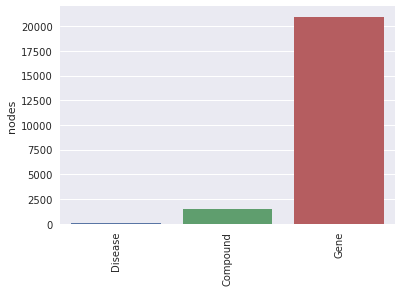

In [49]:
ax = seaborn.barplot(x='metanode', y='nodes', data=metanode_df.sort_values('nodes'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('nodes');

/home/ubuntu/anaconda3/envs/integrate/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


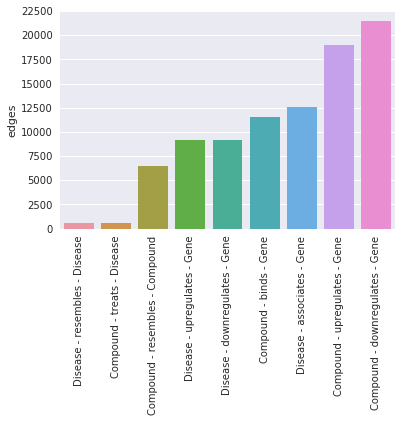

In [50]:
ax = seaborn.barplot(x='metaedge', y='edges', data=metaedge_df.sort_values('edges'))
for tick in ax.get_xticklabels():
    tick.set_rotation(90)
ax.set_xlabel(''); ax.set_ylabel('edges');